# Maximisation couple moyen (non-linéaire)

Ce notebook propose d'optimiser le rotor d'une machine synchro-réluctante sans aimant à une paire de pôle en vue de maximiser le couple moyen.
Dans ce cas particulier, le couple moyen est directement relié à la différence de perméance magnétique du rotor dans l'axe direct d et l'axe en quadrature q.

Le problème étudié est donc la maximisation de cette différence de perméance via la différence de compliance magnétique. Il est possible de démontrer que ce problème est mal posé.

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry
from netgen.geom2d import CSG2d, Circle, Rectangle
#from netgen.geom2d import unit_square
from copy import copy
from numpy.random import randint
import numpy as np
import matplotlib.pyplot as plt
from ngsolve.solvers import Newton

importing NGSolve-6.2.2105-9-g5a835126f


## 1) Définition du maillage

La première étape consiste à définir une géométrie (disque), ainsi que la finesse de maillage associée.

In [2]:
def generate_fitted_circle_mesh(N):
    geo = CSG2d()
    R=1
    x = R*2*(np.append(np.insert(np.arange(0.5,N+0.5),0,0),N)/N-0.5)
    
    circle1 = Circle( center=(0,0), radius=R, bc="left_up" ) * Rectangle( pmin=(-R,0), pmax=(0,R))
    circle2 = Circle( center=(0,0), radius=R, bc="left_bot" ) * Rectangle( pmin=(-R,-R), pmax=(0,0))
    circle3 = Circle( center=(0,0), radius=R, bc="right_bot" ) * Rectangle( pmin=(0,-R), pmax=(R,0))
    circle4 = Circle( center=(0,0), radius=R, bc="right_up" ) * Rectangle( pmin=(0,0), pmax=(R,R))
    
    materials = ["iron","air"]
    
    for i in range(len(x)-1):
        geo.Add(Rectangle( pmin=(x[i],-R), pmax=(x[i+1],R), mat = materials[i%2] ) * (circle1 + circle2 + circle3 +circle4))

    #m = geo.GenerateMesh(maxh=max([R/N,1/30])) # On doit fixer la taille du maillage sinon le volume change à cause des elts grossiers
    m = geo.GenerateMesh(maxh=1/70)
    return Mesh(m)


## 2) Définition des problèmes éléments finis

L'objectif est ici de maximiser la différence de compliance magnétique pour deux chargement distincts. On va résoudre le problème magnétostatique dual ; pour cela, remarquons qu'en l'absence de termes sources:

$$ \overrightarrow{\text{rot}} ~ \overrightarrow{h} = 0 $$

On pose donc $\phi$ un potentiel scalaire tel que $\overrightarrow{h} = \overrightarrow{\text{grad}} ~ \phi$, qui vérifie donc dans $\Omega$:
$$ \text{div}( \mu ~\overrightarrow{\text{grad}} ~ \phi ) = 0 $$

$\phi$ est un champ scalaire qu'on va supposer appartenant à $H^1$. Les conditions aux bords sont de Neumann. La solution est unique à une constante près. Les deux problèmes à résoudre s'écrivent donc :

$$\left \{
\begin{array}{l}
     \text{div}( \mu ~\overrightarrow{\text{grad}} ~ \phi ) = 0 \\
     \frac{\partial \phi}{\partial n} = \Phi ~ \text{sur} ~ \Gamma_1 \bigcup \Gamma_2 \\
     \frac{\partial \phi}{\partial n} = - \Phi ~ \text{sur} ~ \Gamma_3 \bigcup \Gamma_4 
\end{array}
\right. $$

$$\left \{
\begin{array}{l}
     \text{div}( \mu ~\overrightarrow{\text{grad}} ~ \phi ) = 0 \\
     \frac{\partial \phi}{\partial n} = \Phi ~ \text{sur} ~ \Gamma_2 \bigcup \Gamma_3 \\
     \frac{\partial \phi}{\partial n} = - \Phi ~ \text{sur} ~ \Gamma_1 \bigcup \Gamma_4 
\end{array}
\right. $$


Sous forme faible, ce problème s'écrit donc :

$$\forall \psi \in H^1, \underbrace{\int_{\Omega} ~\overrightarrow{\text{grad}} ~ \psi \cdot  \mu ~\overrightarrow{\text{grad}} ~ \phi}_{\text{forme bilinéaire} } = \underbrace{\int_{\Gamma_+} \psi \Phi - \int_{\Gamma_-} \psi \Phi}_{\text{forme linéaire}} $$

Par ailleurs, on suppose que $\mu$ est constante par morceau. On suppose aussi que $\mu$ dépend de $h$ de la façon suivante :

$$ \mu(h) = \mu_0 *\left(1 + 0.25 \frac{20 h}{1 + (20 h)^2 / h_{sat}} \right)  $$

Avec $h_{sat} = 10 kA/m$.

In [3]:
hsat = 6000
mu0 = 4e-7*np.pi


def B(h):
    return mu0*(1000*h-(atan(h/hsat)/pi+0.5)*999.*h );


def h2mu(h):
    return B(h)/h

def mu(phi,mesh):
    mu0 = 4e-7*np.pi
    return mesh.MaterialCF({ "iron" : h2mu(sqrt(1e-20+grad(phi)*grad(phi))) }, default=mu0)

On définit ensuite les densités

In [4]:
PHI = 1;


def solvePb(mesh):
    fespace_H1 = H1(mesh, order=1)
    fespace_H1.FreeDofs()[0] = False
    phi = fespace_H1.TrialFunction()
    psi = fespace_H1.TestFunction()
    
    K1 = BilinearForm(fespace_H1, symmetric=True)
    K1 +=  grad(psi)*mu(phi,mesh)*grad(phi)*dx
    
    K2 = BilinearForm(fespace_H1, symmetric=True)
    K2 += grad(psi)*mu(phi,mesh)*grad(phi)*dx

    K1 += psi*PHI*sqrt(1-x**2)*ds(definedon=mesh.Boundaries("right_bot|left_bot"))
    K1 += -psi*PHI*sqrt(1-x**2)*ds(definedon=mesh.Boundaries("left_up|right_up"))

    K2 += psi*PHI*sqrt(1-y**2)*ds(definedon=mesh.Boundaries("left_up|left_bot"))
    K2 += -psi*PHI*sqrt(1-y**2)*ds(definedon=mesh.Boundaries("right_up|right_bot"))
    
    phi1 = GridFunction(fespace_H1)
    phi2 = GridFunction(fespace_H1)
    Newton(K1,phi1, freedofs = fespace_H1.FreeDofs() ,printing=False,maxerr=1e-10)
    Newton(K2,phi2, freedofs = fespace_H1.FreeDofs() ,printing=False,maxerr=1e-10)
    
    #Newton(K1,phi1, freedofs = fespace_H1.FreeDofs())
    #Newton(K2,phi2, freedofs = fespace_H1.FreeDofs())
    
    return(phi1, phi2)

def compliance(phi,mesh):
    mu = mesh.MaterialCF({ "iron" : h2mu(sqrt(1e-12+grad(phi)*grad(phi))) }, default=mu0)
    return Integrate(grad(phi)*mu* grad(phi)*dx,mesh)

On définit ensuite la stratégie de résolution non-linéaire. On utilise la méthode de Newton, qui consiste à annuler une fonction (le résidu) par approximations affines successives.
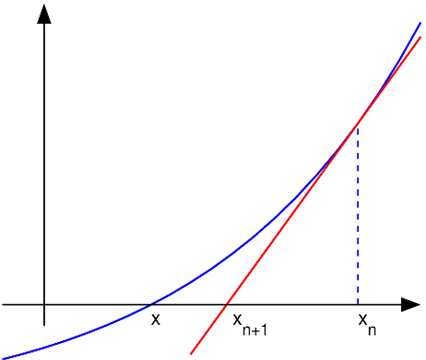

En dérivant le résidu, on trouve :

$$ \overbrace{\langle h^*, \partial_h [\mu(h_k) h_k] \underbrace{(h_{k+1} - h_k)}_{\Delta h_k} \rangle}^{\text{dérivée du résidu}} + \underbrace{\langle h^*, \mu(h_k) h_k \rangle - l_k(h^*)}_{\text{résidu}} = 0 $$

Avec 

$$\partial_h [\mu(h_k) h_k] = I_d \mu(h_k) + h_k \otimes \partial_|h| \mu . \mathrm{d}_\phi |h|$$

Après avoir résolu cette équation, on trouve :

$$ h_{k+1} = h_k + \Delta h_k $$

(On peut éventuellementmettre un coefficient d'amortissement)

In [5]:
J1=[]
J2=[]
Jdiff = []
temoin = []
maxN = 70
for i in range(2,maxN,4):
    mesh = generate_fitted_circle_mesh(i)
    phi1, phi2 = solvePb(mesh)
    
    j1 = compliance(phi1,mesh);
    j2 = compliance(phi2,mesh);
    print([j1,j2])
    J1.append(copy(j1))
    J2.append(copy(j2))
    Jdiff.append(copy(j1-j2))
    t =  GridFunction(L2(mesh))
    t.Set(1)
    temoin.append(Integrate(1,mesh))

[593745.5806340744, 1525020.907615332]
[168239.66393164123, 1309579.6411425692]
[103972.5989175773, 1279810.0315035044]
[78614.87618685522, 1269363.6544817053]
[65045.586533047564, 1264317.286437934]
[56457.80156454982, 1261441.1814090048]
[50543.259632595, 1259614.4907281946]
[46175.00317431097, 1258374.3210484185]
[42782.32064998684, 1257490.7238499552]
[40212.499903897144, 1256822.5227304716]
[37832.75521497704, 1256319.3915314018]
[36070.6620191813, 1255918.438700617]
[34544.918412201485, 1255593.7400913204]
[33303.92477400155, 1255325.0107189445]
[31999.214164663346, 1255114.6132199413]
[30805.919942371147, 1254933.1901889192]
[29964.455540110765, 1254773.7589983342]


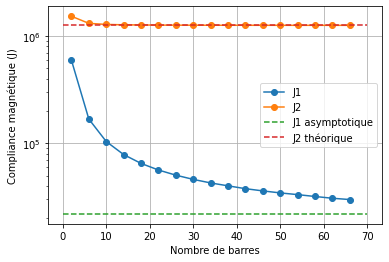

In [10]:
Jpar = 1./(0.5*2.8411e-04+(1-0.5)*mu0)*pi
Jser = (0.5/5.0016e-04+0.5/mu0)*pi

plt.semilogy(list(range(2,maxN,4)),J1,'-o')
plt.semilogy(list(range(2,maxN,4)),J2,'-o')
plt.semilogy([0,maxN],[Jpar,Jpar],'--')
plt.semilogy([0,maxN],[Jser,Jser],'--')
plt.legend(["J1","J2","J1 asymptotique","J2 théorique"])
plt.xlabel("Nombre de barres")
plt.ylabel("Compliance magnétique (J)")
plt.grid()
plt.savefig("test.pdf",format = 'pdf')

In [7]:
mesh = generate_fitted_circle_mesh(70)
phi1, phi2 = solvePb(mesh)

In [8]:
Draw(mu(phi,mesh)*grad(phi1),mesh)

NameError: name 'phi' is not defined

## 3) Optimisation



In [ ]:
Jpar

In [ ]:
print(objective(phi1,phi2,rho))

In [ ]:

Draw(rho,mesh)